# ***Sentiment Analysis on Amazon Musical Instruments Reviews***


---


*Web Portals get a vast amount of feedback from the users. To go through all the feedback can be a tedious job. You have to categorize opinions expressed in feedback forums. This can be utilized for a feedback management system. We classify individual comments/reviews and we also determine overall rating based on individual comments/reviews so that company can get a complete idea on feedback provided by the customers and can take care of those particular fields. This makes more loyal Customers to the company, increase in business , fame, brand value, profits.*

*With the help of **Sentimental Analysis**, we tend to help the organization to understand better about their customer feedback so that they can concentrate on the  issues faced by the customers*




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pwd
%cd "/content/drive/MyDrive/Sentiment_Analysis_Project" 
%pwd

/content/drive/MyDrive/Sentiment_Analysis_Project


'/content/drive/MyDrive/Sentiment_Analysis_Project'

### **Import Libararies**

In [ ]:
import pandas as pd
import numpy as np

# nltk 
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn

# for regular expression
import re

# for visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nltk downloads 
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('averaged_perceptron_tagger') #  averaged_perceptron_tagger is used for tagging words with their parts of speech 
nltk.download('pos_tag')
nltk.download('punkt')    # punkt is used for tokenising sentences i.e divides a text into a list of sentences by using an unsupervised algorithm to build a model 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Error loading pos_tag: Package 'pos_tag' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##**Import Dataset**

In [ ]:
data = pd.read_csv("Musical_instruments_reviews.csv")
data.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB


###**Manipulating dataset according to the requirements**

### checking for duplicate values

In [ ]:
# data.pivot_table(index=["reviewerID","reviewerName","asin"], aggfunc='size').tail(50)
data[data[["reviewerID","reviewerName","asin"]].duplicated() == True] # no duplicates

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime


### checking for null values

In [ ]:
data.isna().sum()  

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

### Handing missing values

In [ ]:
# handling missing values of required fields
data.reviewText.fillna("",inplace = True)

data.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

#### Since we only require "ReviewText","Overall" and "Summary" columns, we delete all the other colums for better results

In [ ]:
data = data.drop(['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime', 'overall'], axis = 1)
data.head()

,reviewText,summary
0,"Not much to write about here, but it does exac...",good
1,The product does exactly as it should and is q...,Jake
2,The primary job of this device is to block the...,It Does The Job Well
3,Nice windscreen protects my MXL mic and preven...,GOOD WINDSCREEN FOR THE MONEY
4,This pop filter is great. It looks and perform...,No more pops when I record my vocals.


In [ ]:
data['feedback'] = data['reviewText'] + ' ' + data['summary']
data = data.drop(['summary','reviewText'],axis = 1)
data.head()

,feedback
0,"Not much to write about here, but it does exac..."
1,The product does exactly as it should and is q...
2,The primary job of this device is to block the...
3,Nice windscreen protects my MXL mic and preven...
4,This pop filter is great. It looks and perform...


## ***Data Preprocessing***

In [ ]:
def preprocess_data(data,name):
    # Proprocessing the data  (converting to lower)
    data[name]=data[name].str.lower()
    # to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
    # to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I)) 
    # to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
    # to remove the handlers
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))   

# Function to tokenize and remove the stopwords    
def rem_stopwords_tokenize(data,name):  
      
    def getting(sen):
        example_sent = sen
        
        filtered_sentence = [] 

        stop_words = set(stopwords.words('english'))             

        word_tokens = word_tokenize(example_sent) 
        
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        
        return filtered_sentence
        
    # Using "getting(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

In [ ]:
lemmatizer = WordNetLemmatizer()   # root words
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x


In [ ]:
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))    

In [ ]:
# Using the preprocessing function to preprocess the hotel data
preprocess_data(data,'feedback')
# Using tokenizer and removing the stopwords
rem_stopwords_tokenize(data,'feedback')
# Converting all the texts back to sentences
make_sentences(data,'feedback')
# Using the Lemmatization function to lemmatize the hotel data
Lemmatization(data,'feedback')
# Converting all the texts back to sentences
make_sentences(data,'feedback')

In [ ]:
data.head()

,feedback
0,much write exactly itsupposed filter pop sound...
1,product exactly quite affordabledid realized d...
2,primary job device block breath would otherwis...
3,nice windscreen protects mxl mic prevents pop ...
4,pop filter great look performs likestudio filt...


In [ ]:
pos=neg=obj=count=0

postagging = []

for review in data['feedback']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None


def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    # Lemmatization
    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []

    
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    # Take the first sense, the most common
    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0
    
senti_score = []

for pos_val in postagging:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  # positive score is stored at 2nd position
            neg = neg + score[2]  # negative score is stored at 3rd position
        except:
            continue
    senti_score.append(pos - neg)
    pos=neg=0    
    
data['sentiment'] = senti_score

In [ ]:
data.head()

,feedback,sentiment
0,much write exactly itsupposed filter pop sound...,1.625
1,product exactly quite affordabledid realized d...,2.625
2,primary job device block breath would otherwis...,2.000
3,nice windscreen protects mxl mic prevents pop ...,2.375
4,pop filter great look performs likestudio filt...,0.000


In [ ]:
overall=[]
for i in range(len(data)):
    if data['sentiment'][i]<= -0.05:
        overall.append('Negative')
    else:
        overall.append('Positive')
        
data['sentiment']=overall

In [ ]:
def convert_sentiment(sentiment):
    if(sentiment=='Negative'):
        return 0
    else:
        return 1  

In [ ]:
data.sentiment = data.sentiment.apply(convert_sentiment)

In [ ]:
data.head(30)

,feedback,sentiment
0,much write exactly itsupposed filter pop sound...,1
1,product exactly quite affordabledid realized d...,1
2,primary job device block breath would otherwis...,1
3,nice windscreen protects mxl mic prevents pop ...,1
4,pop filter great look performs likestudio filt...,1
5,good thatbought another one love heavy cord go...,1
6,used monster cable year good reason lifetime w...,1
7,use cable run output pedal chain input fender ...,1
8,perfect epiphone sheraton monster cable well c...,0
9,monster make best cable andlifetime warranty d...,1


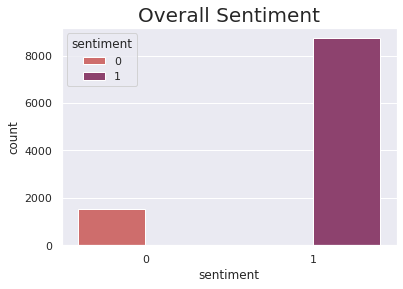

In [ ]:
sns.set(style="darkgrid")
bar = sns.countplot(x = 'sentiment' , hue = 'sentiment' , data = data, palette="flare")
bar.set_title("Overall Sentiment", size = 20)
plt.show()

######***we can tell by this plot, that the data is imbalanced***

##**Creating Word Cloud**
####(visualize the frequent words)

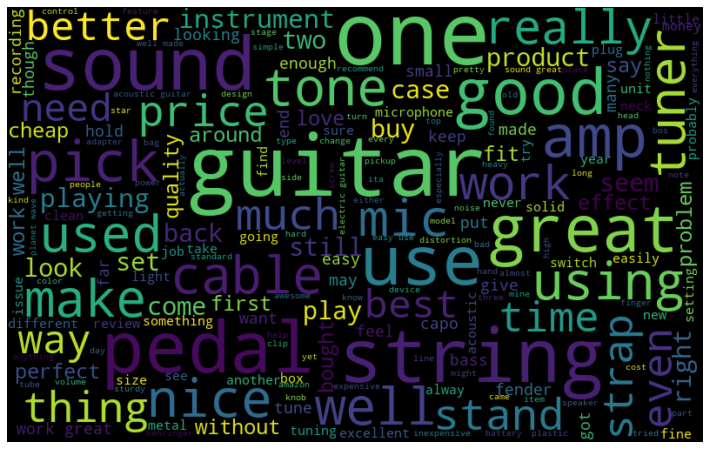

In [ ]:
all_words = " ".join([sentence for sentence in data['feedback']]) 

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
X = data['feedback']
Y = data['sentiment']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,2))
  
X=tf.fit_transform(X)

In [ ]:
import pickle 
filename = 'tfidf.pkl'
with open(filename, 'wb') as file:
  pickle.dump(tf,file)

###**Balancing the dataset**

In [ ]:
from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import NearMiss

smk = SMOTETomek(random_state=42 , sampling_strategy = 0.8)
X_res,y_res=smk.fit_sample(X,Y)

unique_elements, counts_elements = np.unique(y_res, return_counts=True)
np.asarray((unique_elements, counts_elements))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


array([[   0,    1],
       [6988, 8735]])

###**Applying Maching Learning Models**

In [ ]:
from sklearn.model_selection import train_test_split
x_train1,x_test1,y_train1,y_test1 = train_test_split(X_res,y_res,test_size = 0.2 , random_state = 0)

In [ ]:
### Logistic Regression 
from sklearn.linear_model import LogisticRegression
### Naive Bayes Classifier - MultinomialNB
from sklearn.naive_bayes import MultinomialNB
### Support Vector Machine
from sklearn import svm
### Decision Trees Classifier
from sklearn.tree import DecisionTreeClassifier
### Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

### Classification Report
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score, recall_score

In [ ]:
MLA_columns = []
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0

#### ***Logistic Regression***

In [ ]:
logreg = LogisticRegression()
logreg.fit(x_train1,y_train1)
y_pred_lr = logreg.predict(x_test1)

In [ ]:
lr_report1=classification_report(y_test1,y_pred_lr,target_names=['0','1'])
print(lr_report1)

#y_pred = logreg.predict(x_train1)
# lr_report2=classification_report(y_train1,y_pred)
# print(lr_report2)

              precision    recall  f1-score   support

           0       1.00      0.49      0.66      1395
           1       0.71      1.00      0.83      1750

    accuracy                           0.77      3145
   macro avg       0.86      0.75      0.74      3145
weighted avg       0.84      0.77      0.75      3145



In [ ]:
alg=LogisticRegression()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Name'] = MLA_name
MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(logreg.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'MLA Precision'] = precision_score(y_test1, y_pred_lr)
MLA_compare.loc[row_index, 'F1 Score']=f1_score(y_test1, y_pred_lr)
row_index+=1

#### ***Multinomial Naive Bayes Classifier***

In [ ]:
mnb=MultinomialNB()
mnb_model=mnb.fit(x_train1,y_train1)

In [ ]:
mnb_bow_predict=mnb_model.predict(x_test1)
# mnb_bow1=mnb_model.predict(x_train1)

In [ ]:
mnb_bow_report = classification_report(y_test1,mnb_bow_predict)
print(mnb_bow_report)

# mnb_bow_repor = classification_report(y_train1,mnb_bow1)
# print(mnb_bow_repor)


              precision    recall  f1-score   support

           0       0.99      0.89      0.93      1395
           1       0.92      0.99      0.95      1750

    accuracy                           0.94      3145
   macro avg       0.95      0.94      0.94      3145
weighted avg       0.95      0.94      0.94      3145



In [ ]:
filename = 'mnb.pkl'
with open(filename, 'wb') as file:
  pickle.dump(mnb_model,file)

In [ ]:
alg=MultinomialNB()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Name'] = MLA_name
MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(mnb_model.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'MLA Precision'] = precision_score(y_test1, mnb_bow_predict)
MLA_compare.loc[row_index, 'F1 Score']=f1_score(y_test1, y_pred_rf)

row_index+=1

#### ***Support Vector Classifier***

In [ ]:
model2 = svm.SVC()
model2.fit(x_train1,y_train1)

# testing
y_pred_svm = model2.predict(x_test1)

c=classification_report(y_test1,y_pred_svm)
print(c)


              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1395
           1       0.91      0.99      0.95      1750

    accuracy                           0.94      3145
   macro avg       0.95      0.93      0.94      3145
weighted avg       0.94      0.94      0.94      3145



In [ ]:
alg=svm.SVC()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Name'] = MLA_name
MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(model2.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'MLA Precision'] = precision_score(y_test1, y_pred_svm)

row_index+=1

#### ***Decision Tree Classifier***

In [ ]:
clf = DecisionTreeClassifier()

#Fit train and test into the model
clf.fit(x_train1, y_train1)

#Predict the result
y_pred_dt = clf.predict(x_test1)

c=classification_report(y_test1,y_pred_dt)
print(c)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1395
           1       0.88      1.00      0.94      1750

    accuracy                           0.93      3145
   macro avg       0.94      0.92      0.92      3145
weighted avg       0.93      0.93      0.92      3145



In [ ]:
alg=DecisionTreeClassifier()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Name'] = MLA_name
MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(clf.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'MLA Precision'] = precision_score(y_test1, y_pred_dt)

row_index+=1

#### ***Random Tree Classifier***

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100,oob_score=True,max_features=5)

random_forest.fit(x_train1, y_train1)

y_pred_rf = random_forest.predict(x_test1)

c=classification_report(y_test1,y_pred_rf)
print(c)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      1395
           1       0.88      1.00      0.94      1750

    accuracy                           0.93      3145
   macro avg       0.94      0.92      0.92      3145
weighted avg       0.93      0.93      0.92      3145



In [ ]:
alg=RandomForestClassifier()
MLA_name = alg.__class__.__name__
MLA_compare.loc[row_index,'MLA Name'] = MLA_name
MLA_compare.loc[row_index, 'MLA Test Accuracy'] = round(random_forest.score(x_test1, y_test1), 4)
MLA_compare.loc[row_index, 'MLA Precision'] = precision_score(y_test1, y_pred_rf)

row_index+=1

### **Confusion Matrices**

In [ ]:
from sklearn.metrics import plot_precision_recall_curve, plot_confusion_matrix

group_names = ['True Neg','False Pos','False Neg','True Pos']

##### ***Logistic Regression***

[[ 684  711]
 [   0 1750]]


Text(0.5, 1.0, '\nLogistic Regression')

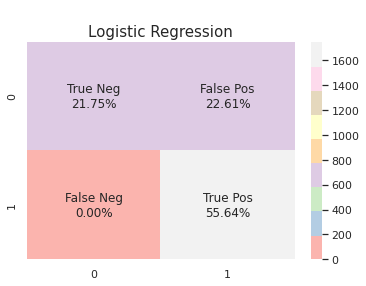

In [ ]:
cf_matrix_lr = confusion_matrix(y_test1, y_pred_lr)
print(cf_matrix_lr)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_lr.flatten()/np.sum(cf_matrix_lr)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_lr, annot=labels, fmt='', cmap='Pastel1')

plt.title('\nLogistic Regression', fontsize = 15)

##### ***Multinomial Naive Bayes Classifier***

[[1239  156]
 [  17 1733]]


Text(0.5, 1.0, '\nMultinomial Naive Bayes Classifier')

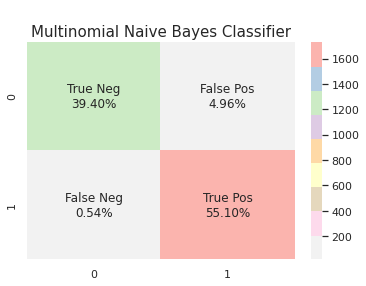

In [ ]:
cf_matrix_nb = confusion_matrix(y_test1, mnb_bow_predict)
print(cf_matrix_nb)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_nb.flatten()/np.sum(cf_matrix_nb)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_nb, annot=labels, fmt='', cmap='Pastel1_r')

plt.title('\nMultinomial Naive Bayes Classifier', fontsize = 15)

##### ***Support Vector Classfier***

[[1215  180]
 [  11 1739]]


Text(0.5, 1.0, '\nSupport Vector Classifier')

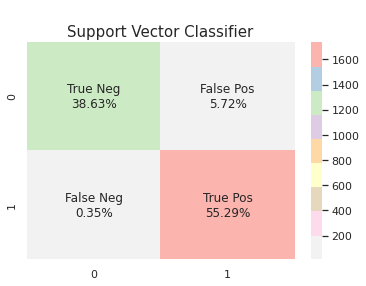

In [ ]:
cf_matrix_svm = confusion_matrix(y_test1, y_pred_svm)
print(cf_matrix_svm)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_svm.flatten()/np.sum(cf_matrix_svm)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_svm, annot=labels, fmt='', cmap='Pastel1_r')

plt.title('\nSupport Vector Classifier', fontsize = 15)

##### ***Decision Tree Classifier***

[[1160  235]
 [   0 1750]]


Text(0.5, 1.0, '\nDecision Tree Classifier')

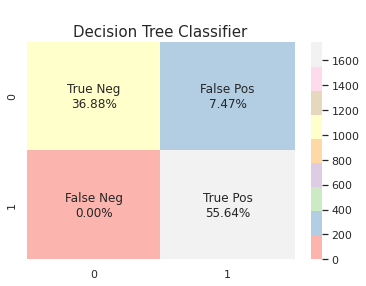

In [ ]:
cf_matrix_dt = confusion_matrix(y_test1, y_pred_dt)
print(cf_matrix_dt)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_dt.flatten()/np.sum(cf_matrix_dt)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_dt, annot=labels, fmt='', cmap='Pastel1')

plt.title('\nDecision Tree Classifier', fontsize = 15)

##### ***Random Tree Classifier***

[[1160  235]
 [   0 1750]]


Text(0.5, 1.0, '\nRandom Tree Classifier')

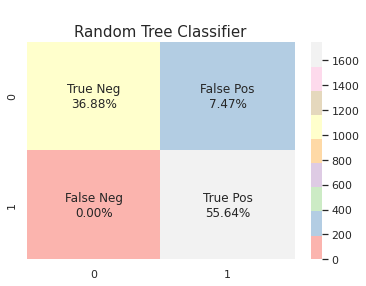

In [ ]:
cf_matrix_rf = confusion_matrix(y_test1, y_pred_rf)
print(cf_matrix_rf)

group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix_rf.flatten()/np.sum(cf_matrix_rf)]
labels = [f'{v1}\n{v2}' for v1,v2 in
          zip(group_names,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix_rf, annot=labels, fmt='', cmap =sns.color_palette("Pastel1"))

plt.title('\nRandom Tree Classifier', fontsize = 15)

## **Accuracy Comparison of various machine learning techniques on our dataset**



In [ ]:
MLA_compare.sort_values(by = ['MLA Test Accuracy'], ascending = False, inplace = True)    
MLA_compare

,MLA Name,MLA Test Accuracy,MLA Precision
1,MultinomialNB,0.9450,0.917417
2,SVC,0.9393,0.906201
3,DecisionTreeClassifier,0.9253,0.881612
4,RandomForestClassifier,0.9253,0.881612
0,LogisticRegression,0.7739,0.711093


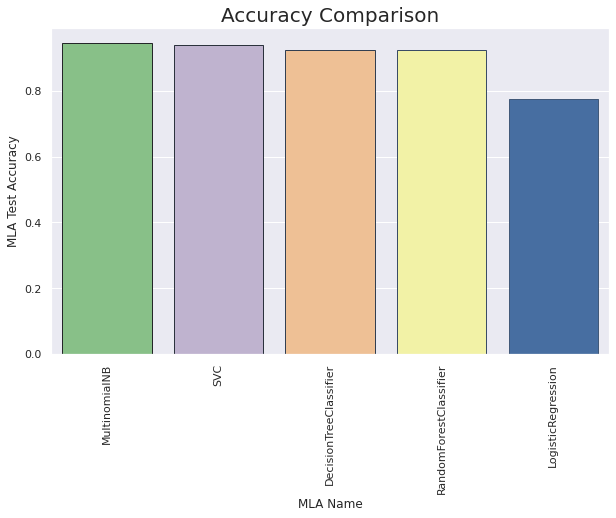

In [ ]:
plt.subplots(figsize=(10,6))
sns.barplot(x="MLA Name", y="MLA Test Accuracy", data=MLA_compare,palette=sns.color_palette("Accent"),edgecolor=sns.dark_palette("#69d",10))
plt.xticks(rotation=90)
plt.title('Accuracy Comparison', size = 20)
plt.show()